In [1]:
import sys
sys.path.append("..")
import petsi
from random import gauss, uniform, random
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

In [2]:
def create_simulator(initial_work, utilization, firing_distribution, **loop_backs):
    # print(f"    Initial work:{initial_work}, utilization={utilization}")
    simulator = petsi.Simulator("Activity time")
    simulator.add_place("ToDo")
    simulator.add_place("Done")

    simulator.add_immediate_transition("start", priority=1)
    simulator.add_inhibitor("is idle", "ToDo", "start")
    for i in range(initial_work):
        simulator.add_constructor(f"initial token #{i}", "start", "ToDo")

    simulator.add_timed_transition("doing", firing_distribution)
    simulator.add_transfer("do", "ToDo", "doing", "Done")

    constructor_weights = 0
    for transition_name, (multiplier, weight) in loop_backs.items():
        if multiplier > 0 and weight > 0:
            # print(f"      {transition_name} multiplier={multiplier}, weight={weight}")
            simulator.add_immediate_transition(transition_name, priority=2, weight=weight)
            simulator.add_transfer(f"{transition_name}", "Done", transition_name, "ToDo")
            for i in range(multiplier-1):
                constructor_weights += weight
                constructor_name = f"more-to-do #{i+1}"
                simulator.add_constructor(constructor_name, transition_name, "ToDo")

    destructor_weight = max(1.0, constructor_weights) / utilization
    # print(f"      vanish weight={destructor_weight}")
          
    simulator.add_immediate_transition("vanish", priority=2, weight=destructor_weight)
    simulator.add_destructor("end", "Done", "vanish")
    
    return simulator

In [3]:
from contextlib import contextmanager
import time

@contextmanager
def timing(activity: str = ""):
    start = time.time()
    yield
    elapsed = time.time() - start
    print(f"Duration of [{activity}]: {elapsed:0.1f} seconds")

In [4]:
def plot_firing_interval(data, description):
    # https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
    from scipy.stats.kde import gaussian_kde
    from scipy.stats import gamma
    from numpy import linspace

    with timing("fitting a gamma distribution"):
        kde = gaussian_kde( data )    
        dist_space = linspace( min(data), max(data), 100 )
        density = kde(dist_space)

        gamma_params = gamma.fit(data)
        print(f"gamma_params={gamma_params}")
        gamma_pdf = gamma.pdf(dist_space, *gamma_params)
        gamma_pdf[gamma_pdf > 1.0] = np.nan
    
    fig, ax = plt.subplots(figsize=(20, 6))
    # plt.figure
    plt.grid(True)
    
    with timing("creating a historgram"):
        ax.hist(data, bins='auto', density=True, label='Empirical density')    
        
    ax.plot( dist_space, density, label='Estimated probability density (KDE)' )
    ax.plot( dist_space, gamma_pdf, label='Gamma distribution fit to the data'  )
    ax.legend()
    ax.text(0.98, 0.7, description, horizontalalignment='right', verticalalignment='center', multialignment='left',
            bbox=dict(boxstyle="round,pad=1", facecolor="w", edgecolor="0.5", alpha=0.5, ),
            transform=ax.transAxes)
    plt.show()
#     plt.figure(figsize=(20, 6))
#     plt.grid(True)
#     plt.loglog( dist_space, density )

In [5]:
from multiprocessing import Pool
from collections import defaultdict
import os
            

def _run_one(args):
    nbr_samples, num_initial_tokens, utilization, firing_distribution, loop_backs = args
    simulator = create_simulator(num_initial_tokens, utilization, firing_distribution, **loop_backs)
    get_transition_observations, = simulator.observe(transition_firing=nbr_samples, transitions=['start'])
    simulator.simulate()
    transition_observations = get_transition_observations()
    return transition_observations

def save_array(file_name_prefix: str, stage: int, metric_name: str, np_array: array):
    filename = f"{file_name_prefix}_{stage}_{metric_name}.array_{np_array.typecode}"
    np_array.tofile(open(filename, "wb"))
    print(f"Saved '{filename}'")

def load_array(file_name_prefix: str, stage: int, metric_name: str, np_array: array = None, typecode=None):
    if np_array is None:
        if typecode is None:
            raise ValueError("np_array and typecode cannot be both None")
        np_array = array(typecode)
    else:
        if typecode is None:
            typecode = np_array.typecode
        else:
            if typecode != np_array.typecode
                raise ValueError(f"np_array.typecode={np_array.typecode} but in the argument typecode={typecode} was povided")
        
    filename = f"{file_name_prefix}_{stage}_{metric_name}.array_{np_array.typecode}"
    file_size = os.stat(filename).st_size
    
    if file_size % np_array.itemsize:
        raise ValueError(f"The size of {filename} is not a multiple of itemsize {np_array.itemsize}")
    
    np_array.fromfile(open(filename, "rb"), int(file_size / np_array.itemsize))
    print(f"Loaded '{filename}'")
    
    return np_array

    
def merge_results(metric_dicts, file_name_prefix):
    transposed = defaultdict(list)
    
    for metric_dict in metric_dicts:
        for metric_name, value_array in metric_dict.items():
            transposed[metric_name].append(value_array)

    all_observations = dict()
    stage = next(c)
    for metric_name, value_array_list in transposed.items():
        np_array = all_observations[metric_name] = np.concatenate(value_array_list)
        save_array(file_name_prefix, stage, metric_name, np_array)
    
    return all_observations

def run(nbr_samples, token_numbers, utilization, firing_distribution, loop_backs, file_name_prefix, do_concurrently=True):
    
    print(f"===================================")
    print(f"{'Parallel' if do_concurrently else 'Sequential'} run, {nbr_samples} samples")
    
    for num_initial_tokens in token_numbers:
        
        print(f"===================================")
        if num_initial_tokens <=10:
            create_simulator(num_initial_tokens, utilization, **loop_backs)
            display(simulator.show())

        with timing(f"the whole iteration"):
            with timing(f"simulating num_initial_tokens={num_initial_tokens}"):

                if do_concurrently:
                    with Pool() as p:
                        transition_observations = \
                            p.map(_run_one, [(int(nbr_samples/os.cpu_count()), num_initial_tokens, utilization, firing_distribution, loop_backs) 
                                            for _ in range(os.cpu_count())]
                                 )
                else:
                    transition_observations = [ _run_one((int(nbr_samples), num_initial_tokens, utilization, firing_distribution, loop_backs)) ]

            flat_transition_observations = merge_results(transition_observations, file_name_prefix)   
            interval = flat_transition_observations['interval']

            description = [f"Initial token count: {num_initial_tokens}"]

            for branch_name, (repeat_count, weight) in loop_backs.items():
                description.append(f"  Multiplier in loop-back '{branch_name}': {repeat_count}")

            description.append("")
            description.append(f"Number of samples:{nbr_samples}")        
            description.append(f"Sample mean:{interval.mean():0.2f}")        
            description = '\n'.join(description)

            print(description)

            with timing(f"plotting num_initial_tokens={num_initial_tokens}"):
                plot_firing_interval(interval, description)
            
            print()            
    print()

In [11]:
np_uniform = np.random.uniform

class FiringDistribution:
    
    def __init__(self): 
        self.x = np_uniform(0.0, 1, 9999)
        self.i = iter(self.x)
        
    def sample(self):
        try:
            return next(self.i)
        except StopIteration:
            self.__init__()
            return next(self.i)

# f = FiringDistribution().sample
# [f() for i in range(10)]

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 761.4 seconds
Saved '00_0_transition.array'
Saved '00_0_firing_time.array'
Saved '00_0_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 0

Number of samples:100000
Sample mean:500.14
gamma_params=(0.30436971304815397, 466.8431257698684, 15.37464392980374)
Duration of [fitting a gamma distribution]: 3.1 seconds
Duration of [creating a historgram]: 0.7 seconds


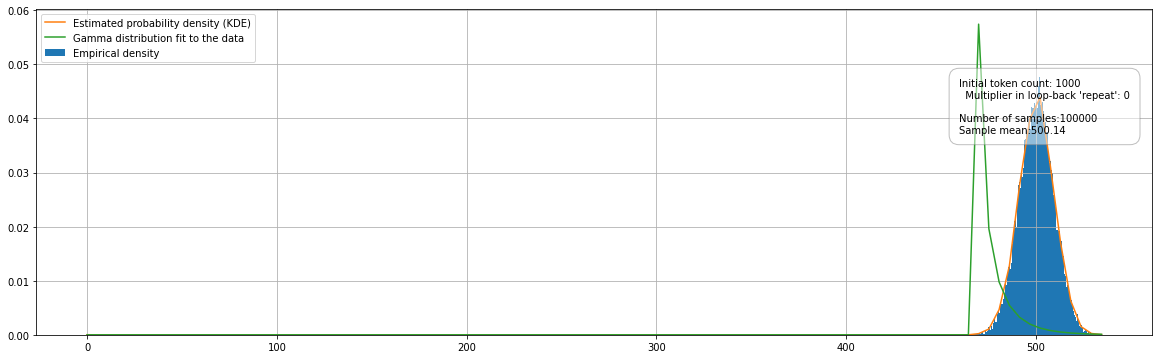

Duration of [plotting num_initial_tokens=1000]: 5.9 seconds

Duration of [the whole iteration]: 767.3 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 1289.2 seconds
Saved '00_1_transition.array'
Saved '00_1_firing_time.array'
Saved '00_1_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 1

Number of samples:100000
Sample mean:875.16
gamma_params=(48.42099245454993, 720.2593214751028, 3.1902602653244454)
Duration of [fitting a gamma distribution]: 4.5 seconds
Duration of [creating a historgram]: 0.6 seconds


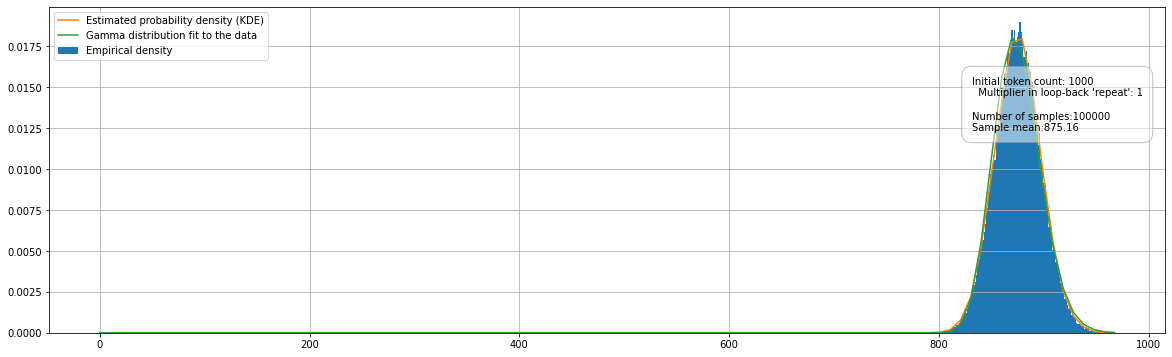

Duration of [plotting num_initial_tokens=1000]: 6.8 seconds

Duration of [the whole iteration]: 1296.1 seconds

Duration of [Overall]: 2063.4 seconds


In [12]:
from itertools import count
c = count(0)

with timing("Overall"): 
    for repeat_count in (0, 1,):
        run(nbr_samples=100000,  
            token_numbers=(1000,), 
            utilization=0.75, 
            firing_distribution=FiringDistribution().sample,
            loop_backs=dict(
                repeat=(repeat_count, 1), 
                # set_back=(0, 4)
            ),
            file_name_prefix='00',
            do_concurrently=True,
           )

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 4092.4 seconds
Saved '00_2_transition.array'
Saved '00_2_firing_time.array'
Saved '00_2_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 3

Number of samples:100000
Sample mean:2750.59
gamma_params=(41.543769291270564, 991.9581354183836, 42.33474048087515)
Duration of [fitting a gamma distribution]: 4.2 seconds
Duration of [creating a historgram]: 0.2 seconds


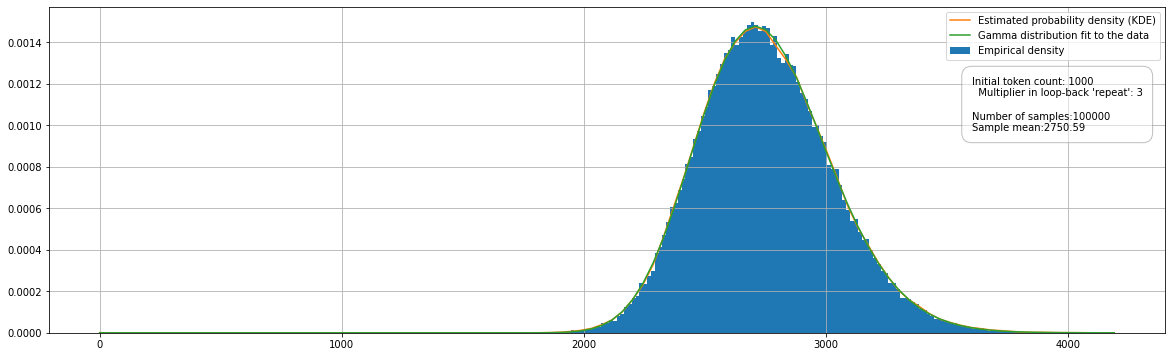

Duration of [plotting num_initial_tokens=1000]: 5.1 seconds

Duration of [the whole iteration]: 4097.5 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 3133.5 seconds
Saved '00_3_transition.array'
Saved '00_3_firing_time.array'
Saved '00_3_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 10

Number of samples:100000
Sample mean:2166.99
gamma_params=(13.63761823120685, 765.1734165543185, 102.73408816727448)
Duration of [fitting a gamma distribution]: 4.2 seconds
Duration of [creating a historgram]: 0.3 seconds


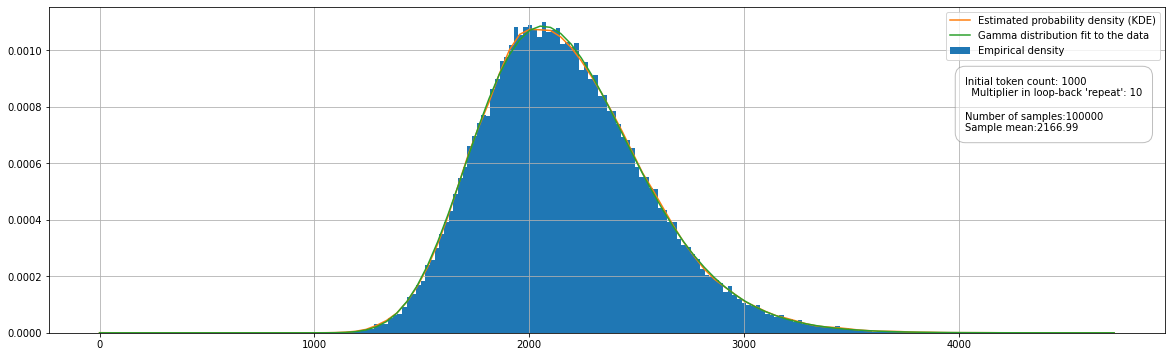

Duration of [plotting num_initial_tokens=1000]: 5.1 seconds

Duration of [the whole iteration]: 3138.7 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 2961.5 seconds
Saved '00_4_transition.array'
Saved '00_4_firing_time.array'
Saved '00_4_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 30

Number of samples:100000
Sample mean:2052.27
gamma_params=(12.02572926172786, -20.781447068955313, 172.38470192321586)
Duration of [fitting a gamma distribution]: 2.6 seconds
Duration of [creating a historgram]: 0.1 seconds


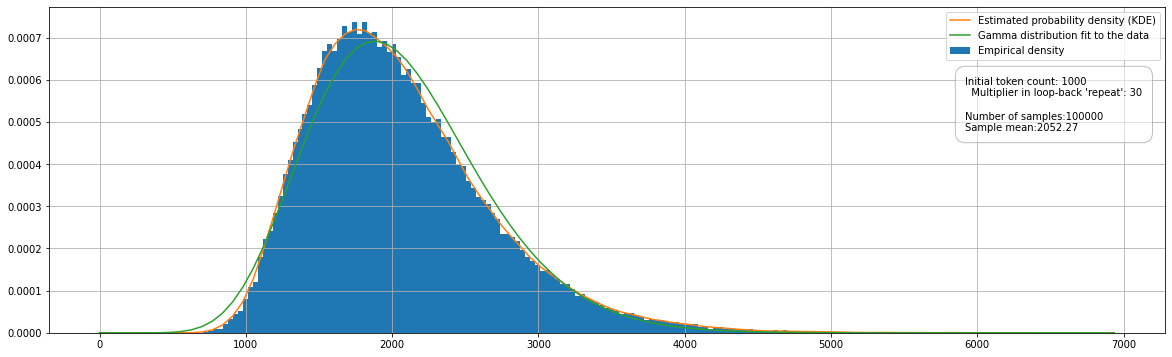

Duration of [plotting num_initial_tokens=1000]: 3.4 seconds

Duration of [the whole iteration]: 2964.9 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 2987.3 seconds
Saved '00_5_transition.array'
Saved '00_5_firing_time.array'
Saved '00_5_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 100

Number of samples:100000
Sample mean:2018.05
gamma_params=(4.1098642805857715, -2.0870104843773616, 491.95913349966065)
Duration of [fitting a gamma distribution]: 3.7 seconds
Duration of [creating a historgram]: 0.2 seconds


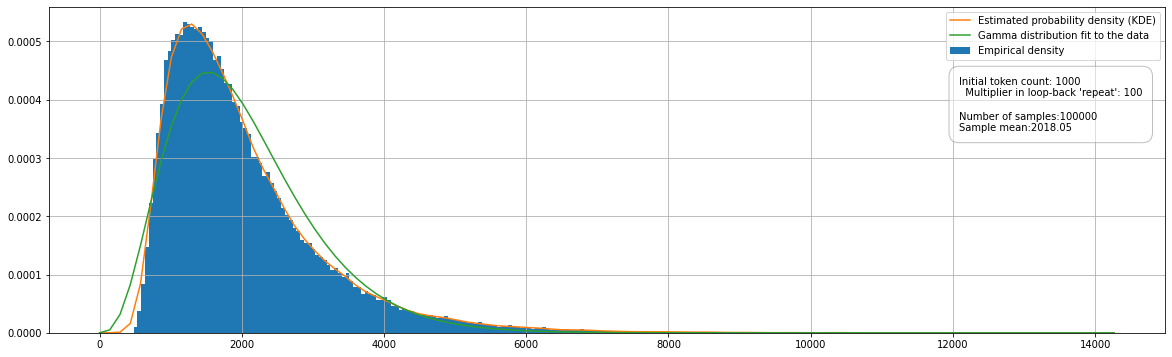

Duration of [plotting num_initial_tokens=1000]: 4.7 seconds

Duration of [the whole iteration]: 2992.0 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 3086.9 seconds
Saved '00_6_transition.array'
Saved '00_6_firing_time.array'
Saved '00_6_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 300

Number of samples:100000
Sample mean:2009.87
gamma_params=(1.8526449535977219, -0.6568750338777907, 1084.0755260201972)
Duration of [fitting a gamma distribution]: 3.7 seconds
Duration of [creating a historgram]: 0.4 seconds


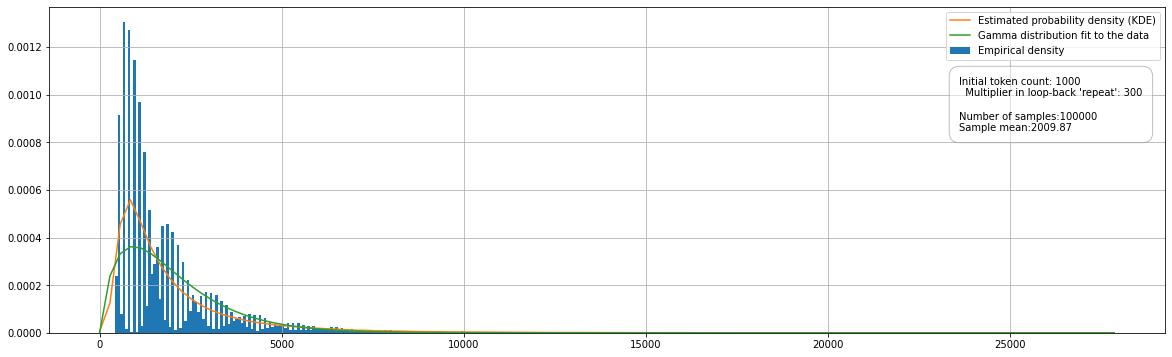

Duration of [plotting num_initial_tokens=1000]: 5.1 seconds

Duration of [the whole iteration]: 3091.9 seconds

Parallel run, 100000 samples
Duration of [simulating num_initial_tokens=1000]: 3073.9 seconds
Saved '00_7_transition.array'
Saved '00_7_firing_time.array'
Saved '00_7_interval.array'
Initial token count: 1000
  Multiplier in loop-back 'repeat': 1000

Number of samples:100000
Sample mean:1983.95
gamma_params=(0.0032478089813384728, 462.09161259606475, 32.66334590344323)
Duration of [fitting a gamma distribution]: 4.3 seconds
Duration of [creating a historgram]: 1.0 seconds


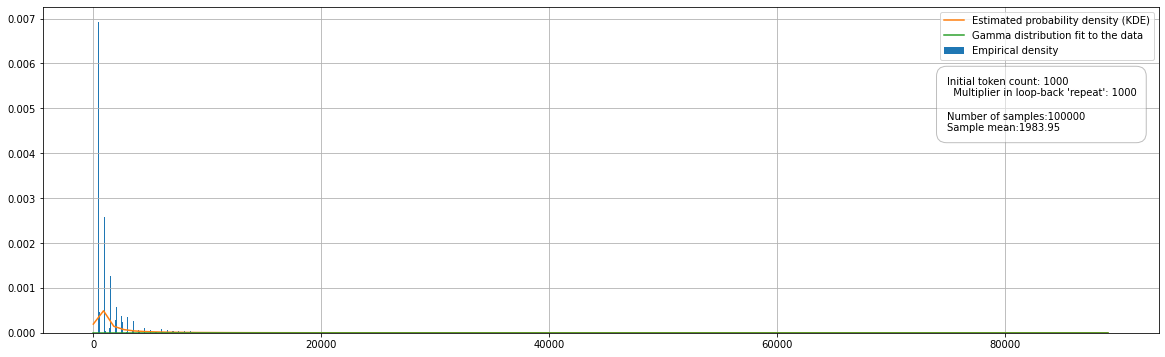

Duration of [plotting num_initial_tokens=1000]: 7.9 seconds

Duration of [the whole iteration]: 3081.9 seconds

Duration of [Overall]: 19366.9 seconds


In [14]:
with timing("Overall"): 
    for repeat_count in (3, 10, 30, 100, 300, 1000):
        run(nbr_samples=100000,  
            token_numbers=(1000,), 
            utilization=0.75, 
            firing_distribution=FiringDistribution().sample,
            loop_backs=dict(
                repeat=(repeat_count, 1), 
                # set_back=(0, 4)
            ),
            file_name_prefix='00',
            do_concurrently=True,
           )

In [13]:
for stage in range(0, 2):
    nbr_samples = 100000
    firing_time = array('d')
    firing_time.fromfile(open(f"00_{stage}_firing_time.array", "rb"), nbr_samples)
    interval = array('d')
    interval.fromfile(open(f"00_{stage}_interval.array", "rb"), nbr_samples)
    transition = array('I')
    transition.fromfile(open(f"00_{stage}_transition.array", "rb"), nbr_samples)
    
    plt.figure(figsize=(20, 6))    
    plt.plot(firing_time)
    plt.show()
    plt.figure(figsize=(20, 6))    
    plt.plot(interval)
    plt.show()
    # plt.plot(transition)

NameError: name 'array' is not defined